In [4]:
%load_ext autoreload
%autoreload 2

from pymongo import MongoClient
from bson.objectid import ObjectId

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

commits_collection = database["commits"]

projects = list(projects_collection.find({'succeeded' : True, 'travis_is_oldest_ci': True, '$or': [ {'scrape_type' : 'travis_1'}, {'scrape_type': 'random_1'} ] } ))

print("Found {} projects with a travis build status date".format(len(projects)))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Found 685 projects with a travis build status date


In [5]:
pr_count = 0
commit_count = 0

prs_per_project = []
commits_per_pr = []

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}, {'commits': 1}))
    
    prs_per_project.append(len(prs))
    
    pr_count += len(prs)
    
    for pr in prs:
        commit_count += len(pr["commits"])
        commits_per_pr.append(len(pr["commits"]))
            
    
print("We have a total of {} prs, and {} commits".format(pr_count, commit_count))

We have a total of 1214826 prs, and 5150112 commits


In [7]:
%matplotlib inline

from matplotlib import pyplot as plt

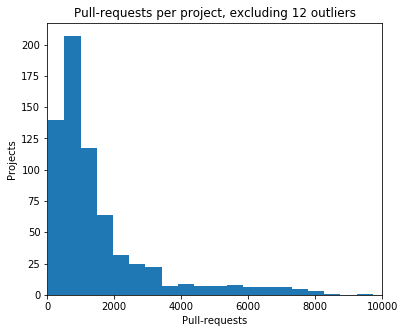

In [36]:
cutoff = 10000

plot_data = [x for x in prs_per_project if x <= cutoff]

f = plt.figure(figsize=(6,5))

plt.hist(plot_data, bins = 20)
plt.xlim((0,cutoff))


plt.title('Pull-requests per project, excluding {} outliers'.format(len(prs_per_project) - len(plot_data)))
plt.xlabel('Pull-requests')
plt.ylabel('Projects')

f.savefig("pr-hist.pdf", bbox_inches="tight")

plt.show()

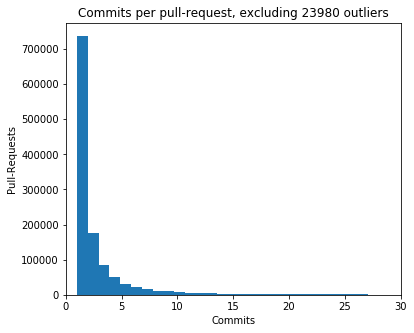

In [42]:
cutoff = 30

plot_data = [x for x in commits_per_pr if x <= cutoff and x > 0]

f = plt.figure(figsize=(6,5))

plt.hist(plot_data, bins = 30)
plt.xlim((0,cutoff))


plt.title('Commits per pull-request, excluding {} outliers'.format(len(commits_per_pr) - len(plot_data)))
plt.xlabel('Commits')
plt.ylabel('Pull-Requests')

f.savefig("commit-hist.pdf", bbox_inches="tight")

plt.show()

# RDD Discovery

## General comments (mean)

In [97]:
from pymongo import MongoClient
from statistics import mean

import analysis_utilities

mongo_client = MongoClient()

database = mongo_client["graduation"]

pull_requests_collection = database["pull_requests"]

projects_collection = database["projects"]

commits_collection = database["commits"]

projects = list(projects_collection.find({'succeeded' : True, 'travis_is_oldest_ci': True}))

In [101]:
from datetime import datetime, timedelta

intervention_period = []
before_periods = []
after_periods = []

period_length = 30

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, False, "status_travis_date", days_delta = period_length/2)
    
               
    travis_date = project["status_travis_date"]
               
    intervention_start = travis_date - timedelta(days=period_length / 2)
    intervention_end = travis_date + timedelta(days=period_length / 2)
    
    intervention_prs = [pr for pr in prs if pr["created_at"] <= intervention_end and pr["created_at"] > intervention_start] 
    
    if  sum([len(pr["raw_comments"]) for pr in intervention_prs]) > 0:

        mean_gen_comments = mean([len(pr["raw_comments"]) for pr in intervention_prs])

        intervention_period.append(mean_gen_comments)
    
    prs_after.sort(key=lambda x: x["created_at"])
    prs_before.sort(key=lambda x: x["created_at"], reverse=True)
                
    def process_prs(prs_todo, target, period_boundaries, next_period):
        index = 0
        period_index = 0

        after_p_end = period_boundaries[1]
        after_p_start = period_boundaries[0]

        prs_in_p = []

        while index < len(prs_todo):
            
            pr = prs_todo[index]

            if pr["created_at"] <= after_p_end and pr["created_at"] > after_p_start:
                prs_in_p.append(pr)

                index += 1

            else:            
                if period_index <= len(target):
                    target.append([])

                if  sum([len(pr["raw_comments"]) for pr in prs_in_p]) > 0:
                    mean_gen_comments = mean([len(pr["raw_comments"]) for pr in prs_in_p])

                    target[period_index].append(mean_gen_comments)

                after_p_start, after_p_end = next_period((after_p_start, after_p_end)) 
                
                prs_in_p = []

                period_index += 1
                
                
                
        if period_index <= len(target):
            target.append([])

        if  sum([len(pr["raw_comments"]) for pr in prs_in_p])> 0:
            mean_gen_comments = mean([len(pr["raw_comments"]) for pr in prs_in_p])

            target[period_index].append(mean_gen_comments)
            
    for_after = lambda pb : (pb[0] + timedelta(days = period_length), pb[1] + timedelta(days = period_length))
    for_before = lambda pb : (pb[0] - timedelta(days = period_length), pb[1] - timedelta(days = period_length))
    
    process_prs(prs_after, after_periods, (intervention_start + timedelta(days = period_length), intervention_end + timedelta(days = period_length)), for_after)
    process_prs(prs_before, before_periods, (intervention_start - timedelta(days = period_length), intervention_end - timedelta(days = period_length)), for_before)

before_periods = list(reversed(before_periods))

take_before = 36
take_after = 36

intervention = take_before + 1

data1 = before_periods[-take_before:] + [intervention_period] + after_periods[:take_after]
               
    

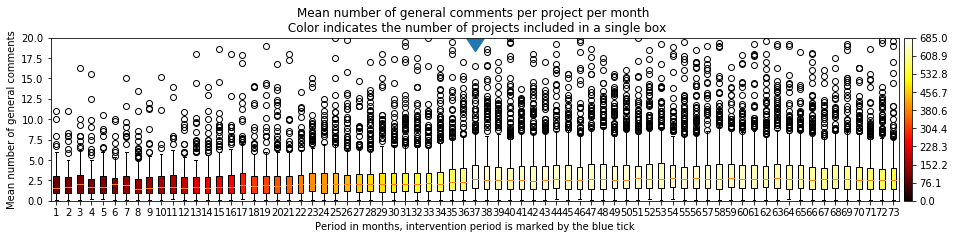

In [120]:
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl

fig = plt.figure(figsize=(18,3))

boxplots = plt.boxplot(data1, patch_artist=True)

plt.scatter([intervention], [20], marker=11, s=[300])

colors = [cm.hot(len(item) / len(projects)) for item in data1]

for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)
    
norm = mpl.colors.Normalize(vmin=0,vmax=len(projects))
sm = plt.cm.ScalarMappable(cmap=cm.hot, norm=norm)
sm.set_array(colors)
fig.colorbar(sm, ticks=np.linspace(start = 0, stop = len(projects), num=10), pad=0.005)

plt.title("Mean number of general comments per project per month \n Color indicates the number of projects included in a single box")
plt.xlabel("Period in months, intervention period is marked by the blue tick")
plt.ylabel("Mean number of general comments")
plt.ylim(0,20)

plt.show()

fig.savefig('rdd-general-comments.png', bbox_inches="tight", dpi=600)

## Review comments (mean)

In [103]:
from datetime import datetime, timedelta

intervention_period = []
before_periods = []
after_periods = []

period_length = 30

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, False, "status_travis_date", days_delta = period_length/2)
    
               
    travis_date = project["status_travis_date"]
               
    intervention_start = travis_date - timedelta(days=period_length / 2)
    intervention_end = travis_date + timedelta(days=period_length / 2)
    
    intervention_prs = [pr for pr in prs if pr["created_at"] <= intervention_end and pr["created_at"] > intervention_start] 
    
    if  sum([len(pr["review_comments"]) for pr in intervention_prs]) > 0:

        mean_rev_comments = mean([len(pr["review_comments"]) for pr in intervention_prs])

        intervention_period.append(mean_rev_comments)
    
    prs_after.sort(key=lambda x: x["created_at"])
    prs_before.sort(key=lambda x: x["created_at"], reverse=True)
                
    def process_prs(prs_todo, target, period_boundaries, next_period):
        index = 0
        period_index = 0

        after_p_end = period_boundaries[1]
        after_p_start = period_boundaries[0]

        prs_in_p = []

        while index < len(prs_todo):
            
            pr = prs_todo[index]

            if pr["created_at"] <= after_p_end and pr["created_at"] > after_p_start:
                prs_in_p.append(pr)

                index += 1

            else:            
                if period_index <= len(target):
                    target.append([])

                if  sum([len(pr["review_comments"]) for pr in prs_in_p]) > 0:
                    mean_rev_comments = mean([len(pr["review_comments"]) for pr in prs_in_p])

                    target[period_index].append(mean_rev_comments)

                after_p_start, after_p_end = next_period((after_p_start, after_p_end)) 
                
                prs_in_p = []

                period_index += 1
                
                
                
        if period_index <= len(target):
            target.append([])

        if  sum([len(pr["review_comments"]) for pr in prs_in_p])> 0:
            mean_rev_comments = mean([len(pr["review_comments"]) for pr in prs_in_p])

            target[period_index].append(mean_rev_comments)
            
    for_after = lambda pb : (pb[0] + timedelta(days = period_length), pb[1] + timedelta(days = period_length))
    for_before = lambda pb : (pb[0] - timedelta(days = period_length), pb[1] - timedelta(days = period_length))
    
    process_prs(prs_after, after_periods, (intervention_start + timedelta(days = period_length), intervention_end + timedelta(days = period_length)), for_after)
    process_prs(prs_before, before_periods, (intervention_start - timedelta(days = period_length), intervention_end - timedelta(days = period_length)), for_before)

before_periods = list(reversed(before_periods))

take_before = 36
take_after = 36

intervention = take_before + 1

data2 = before_periods[-take_before:] + [intervention_period] + after_periods[:take_after]

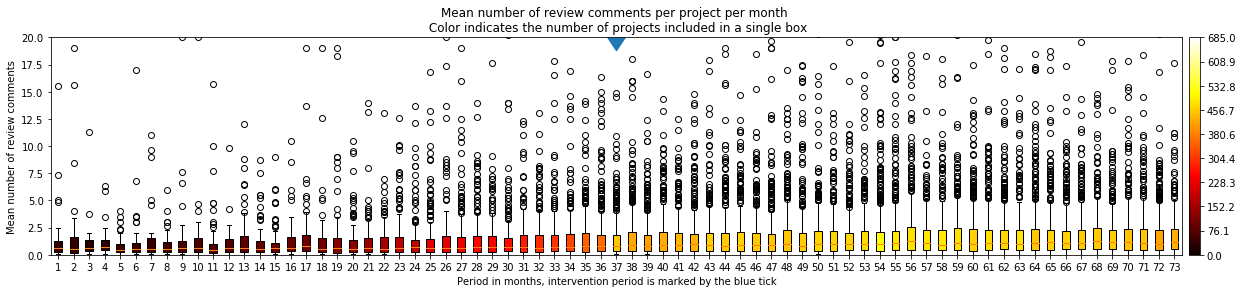

In [104]:
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl

fig = plt.figure(figsize=(24,4))

boxplots = plt.boxplot(data2, patch_artist=True)

plt.scatter([intervention], [20], marker=11, s=[300])

colors = [cm.hot(len(item) / len(projects)) for item in data2]

for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)
    
norm = mpl.colors.Normalize(vmin=0,vmax=len(projects))
sm = plt.cm.ScalarMappable(cmap=cm.hot, norm=norm)
sm.set_array(colors)
fig.colorbar(sm, ticks=np.linspace(start = 0, stop = len(projects), num=10), pad=0.005)

plt.title("Mean number of review comments per project per month \n Color indicates the number of projects included in a single box")
plt.xlabel("Period in months, intervention period is marked by the blue tick")
plt.ylabel("Mean number of review comments")
plt.ylim(0,20)

plt.show()

fig.savefig('rdd-review-comments.pdf', bbox_inches="tight")

## Effective review comments (Mean)

In [105]:
from datetime import datetime, timedelta

intervention_period = []
before_periods = []
after_periods = []

period_length = 30

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, False, "status_travis_date", days_delta = period_length/2)
    
               
    travis_date = project["status_travis_date"]
               
    intervention_start = travis_date - timedelta(days=period_length / 2)
    intervention_end = travis_date + timedelta(days=period_length / 2)
    
    intervention_prs = [pr for pr in prs if pr["created_at"] <= intervention_end and pr["created_at"] > intervention_start] 
    
    
    if  sum([len([comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]]) for pr in intervention_prs]) > 0:

        mean_eff_comments = mean([len([comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]]) for pr in intervention_prs])

        intervention_period.append(mean_eff_comments)
    
    prs_after.sort(key=lambda x: x["created_at"])
    prs_before.sort(key=lambda x: x["created_at"], reverse=True)
                
    def process_prs(prs_todo, target, period_boundaries, next_period):
        index = 0
        period_index = 0

        after_p_end = period_boundaries[1]
        after_p_start = period_boundaries[0]

        prs_in_p = []

        while index < len(prs_todo):
            
            pr = prs_todo[index]

            if pr["created_at"] <= after_p_end and pr["created_at"] > after_p_start:
                prs_in_p.append(pr)

                index += 1

            else:            
                if period_index <= len(target):
                    target.append([])

                if  sum([len([comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]]) for pr in prs_in_p]) > 0:
                    mean_eff_comments = mean([len([comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]]) for pr in prs_in_p])

                    target[period_index].append(mean_eff_comments)

                after_p_start, after_p_end = next_period((after_p_start, after_p_end)) 
                
                prs_in_p = []

                period_index += 1
                
                
                
        if period_index <= len(target):
            target.append([])

        if  sum([len([comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]]) for pr in prs_in_p])> 0:
            mean_eff_comments = mean([len([comment for comment in pr["review_comments"] if 'is_effective' in comment and comment["is_effective"]]) for pr in prs_in_p])

            target[period_index].append(mean_eff_comments)
            
    for_after = lambda pb : (pb[0] + timedelta(days = period_length), pb[1] + timedelta(days = period_length))
    for_before = lambda pb : (pb[0] - timedelta(days = period_length), pb[1] - timedelta(days = period_length))
    
    process_prs(prs_after, after_periods, (intervention_start + timedelta(days = period_length), intervention_end + timedelta(days = period_length)), for_after)
    process_prs(prs_before, before_periods, (intervention_start - timedelta(days = period_length), intervention_end - timedelta(days = period_length)), for_before)

before_periods = list(reversed(before_periods))

take_before = 36
take_after = 36

intervention = take_before + 1

data3 = before_periods[-take_before:] + [intervention_period] + after_periods[:take_after]

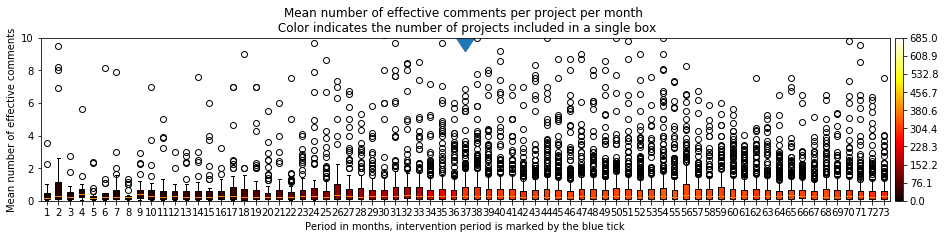

In [121]:
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl

fig = plt.figure(figsize=(18, 3))

boxplots = plt.boxplot(data3, patch_artist=True)

plt.scatter([intervention], [10], marker=11, s=[300])

colors = [cm.hot(len(item) / len(projects)) for item in data3]

for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)
    
norm = mpl.colors.Normalize(vmin=0,vmax=len(projects))
sm = plt.cm.ScalarMappable(cmap=cm.hot, norm=norm)
sm.set_array(colors)
fig.colorbar(sm, ticks=np.linspace(start = 0, stop = len(projects), num=10), pad=0.005)

plt.title("Mean number of effective comments per project per month \n Color indicates the number of projects included in a single box")
plt.xlabel("Period in months, intervention period is marked by the blue tick")
plt.ylabel("Mean number of effective comments")
plt.ylim(0,10)

plt.show()

fig.savefig('rdd-eff-comments.png', bbox_inches="tight", dpi=600)

## Commits after create (mean)

In [107]:
from datetime import datetime, timedelta

intervention_period = []
before_periods = []
after_periods = []

period_length = 30

def commits_after_create(prs):
    res = []
    for pr in prs:
        count = 0
        for sha in pr["commits"]:
            commit = commits_collection.find_one({'sha': sha})
            
            if "date" in commit and pr["created_at"] < commit["date"]:
                count += 1
                
        res.append(count)
        
    return res
            
            

for project in projects:
    prs = list(pull_requests_collection.find({'project_name': project["full_name"].split("/")[1],'project_owner': project["full_name"].split("/")[0]}))
    
    prs_before, prs_after = analysis_utilities.split_prs_on_build_date(project, prs, False, "status_travis_date", days_delta = period_length/2)
    
               
    travis_date = project["status_travis_date"]
               
    intervention_start = travis_date - timedelta(days=period_length / 2)
    intervention_end = travis_date + timedelta(days=period_length / 2)
    
    intervention_prs = [pr for pr in prs if pr["created_at"] <= intervention_end and pr["created_at"] > intervention_start] 
    
    
    if  sum(commits_after_create(intervention_prs)) > 0:

        mean_eff_comments = mean(commits_after_create(intervention_prs))

        intervention_period.append(mean_eff_comments)
    
    prs_after.sort(key=lambda x: x["created_at"])
    prs_before.sort(key=lambda x: x["created_at"], reverse=True)
                
    def process_prs(prs_todo, target, period_boundaries, next_period):
        index = 0
        period_index = 0

        after_p_end = period_boundaries[1]
        after_p_start = period_boundaries[0]

        prs_in_p = []

        while index < len(prs_todo):
            
            pr = prs_todo[index]

            if pr["created_at"] <= after_p_end and pr["created_at"] > after_p_start:
                prs_in_p.append(pr)

                index += 1

            else:            
                if period_index <= len(target):
                    target.append([])

                if  sum(commits_after_create(prs_in_p)) > 0:
                    mean_eff_comments = mean(commits_after_create(prs_in_p))

                    target[period_index].append(mean_eff_comments)

                after_p_start, after_p_end = next_period((after_p_start, after_p_end)) 
                
                prs_in_p = []

                period_index += 1
                
                
                
        if period_index <= len(target):
            target.append([])

        if  sum(commits_after_create(prs_in_p))> 0:
            mean_eff_comments = mean(commits_after_create(prs_in_p))

            target[period_index].append(mean_eff_comments)
            
    for_after = lambda pb : (pb[0] + timedelta(days = period_length), pb[1] + timedelta(days = period_length))
    for_before = lambda pb : (pb[0] - timedelta(days = period_length), pb[1] - timedelta(days = period_length))
    
    process_prs(prs_after, after_periods, (intervention_start + timedelta(days = period_length), intervention_end + timedelta(days = period_length)), for_after)
    process_prs(prs_before, before_periods, (intervention_start - timedelta(days = period_length), intervention_end - timedelta(days = period_length)), for_before)

before_periods = list(reversed(before_periods))

take_before = 36
take_after = 36

intervention = take_before + 1

data4 = before_periods[-take_before:] + [intervention_period] + after_periods[:take_after]

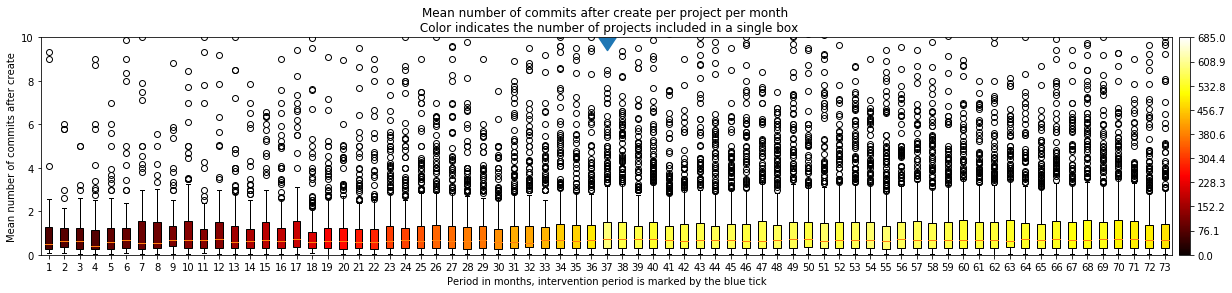

In [108]:
import matplotlib.cm as cm
import numpy as np
import matplotlib as mpl

fig = plt.figure(figsize=(24,4))

boxplots = plt.boxplot(data4, patch_artist=True)

plt.scatter([intervention], [10], marker=11, s=[300])

colors = [cm.hot(len(item) / len(projects)) for item in data4]

for patch, color in zip(boxplots['boxes'], colors):
    patch.set_facecolor(color)
    
norm = mpl.colors.Normalize(vmin=0,vmax=len(projects))
sm = plt.cm.ScalarMappable(cmap=cm.hot, norm=norm)
sm.set_array(colors)

plt.title("Mean number of commits after create per project per month \n Color indicates the number of projects included in a single box")
plt.xlabel("Period in months, intervention period is marked by the blue tick")
plt.ylabel("Mean number of commits after create")
plt.ylim(0,10)

fig.colorbar(sm, ticks=np.linspace(start = 0, stop = len(projects), num=10), pad=0.005)

plt.show()

fig.savefig('rdd-commits-after-create.pdf', bbox_inches="tight")

# Average number of comments per PR

take note, we filter such that we only calculate the numbers over the projects that have been analyzed in the RDD models. 

In [15]:
import pandas as pd

review_comments = []
general_comments = []

used_data = pd.read_csv("../generated/metrics_for_time_series.csv")

project_slugs = used_data["ProjectName"].unique().tolist()

for project in projects:
    
    if project["full_name"] in project_slugs:
        for pr in list(pull_requests_collection.find({'project_name': project["name"], "project_owner" : project["owner"]["login"]}, {'bigrams': 0, 'raw_comments.bigrams': 0, 'review_comments.bigrams':0})):
            review_comments.append(len(pr["review_comments"]))
            general_comments.append(len(pr["raw_comments"]))

In [16]:
from statistics import mean, median

print("Mean number of general comments per PR {}, mean review comments PR {}".format(mean(general_comments), mean(review_comments)))
print("Median number of general comments per PR {}, median review comments PR {}".format(median(general_comments), median(review_comments)))

Mean number of general comments per PR 3.0820907474176913, mean review comments PR 1.4727759139569312
Median number of general comments per PR 1, median review comments PR 0


# Trend plots

The following cells generate a single trend plot for each of the independent variables used during the RDD modeling. 